In [123]:
import psycopg2
from sqlalchemy import create_engine

import pandas as pd
import numpy as np
import string

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, roc_curve, roc_auc_score, mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from create_staging_tables import create_loyalty_scores_df
from clean_for_model import prepare_bill_text_for_clean_df

import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
engine = create_engine('postgresql://localhost:5432/wa_leg_staging')

In [3]:
merged_final_df = pd.read_sql_query('select * from "merged_final"',con=engine)
rep_score_df = pd.read_sql_query('select * from "rep_score"',con=engine)
bill_text_df = pd.read_sql_query('select * from "bill_text"',con=engine)

In [4]:
bill_text_df_cleaned = prepare_bill_text_for_clean_df(bill_text_df)

In [5]:
def create_clean_X(merged_final_df, bill_text_df, rep_score_df):
    
    # Add bill_text
    clean = merged_final_df.merge(bill_text_df, how='left', on=['unique_id', 'htm_url'])
    clean.drop(['index_x', 'index_y'], axis=1, inplace=True)
    clean.rename(columns={'sponsor_party': 'primary_sponsor_party'}, inplace=True)

    
    # Add rep_score and replace -1 values, then make dem_score
    clean['bill_num'] = clean['bill_id'].apply(lambda x: x.split()[1])
    clean['bill_num_unique'] = clean['biennium'] + ' ' + clean['bill_num']
    clean = clean.merge(rep_score_df, how='left', on='bill_num_unique')

    def replace_with_p_sponsor_party(row):
        primary_sponsor_party = row['primary_sponsor_party']
        if row['rep_score'] == -1:
            return primary_sponsor_party
        else:
            return row['rep_score']
    clean['rep_score'] = clean.apply(replace_with_p_sponsor_party, axis=1)
    clean['dem_score'] = 1 - clean['rep_score']
    
    
    # Add loyalty scores
#     clean = clean.merge(loyalty_df, how = 'left', on='voter_id')
#     clean.drop(['index_x', 'index_y'], axis=1, inplace=True)
    
    
    # Feature Engineering functions
    def create_congress_nums(biennium):
        '''Numbers bienniums so that 1991 is 1 and 1993 is 3.'''
        first_year = int((biennium.split('-'))[0])
        return first_year - 1990
    
    def find_num_sponsors(secondary_sponsors):
        if type(secondary_sponsors) == str:
            return round((len(secondary_sponsors) / 5) + 1)
        else: return 1
        
    def remove_neg(num):
        if num < 0:
            return 0
        else: return num
    
    # Feature Engineering
    clean['bill_length'] = clean['bill_text'].apply(lambda x: len(x))
    clean['congress_num'] = clean['biennium'].apply(create_congress_nums)
    clean['num_sponsors'] = clean['secondary_sponsors'].apply(find_num_sponsors)
    
    clean['vote_year'] = clean['vote_date'].apply(lambda x: x.year)
    clean['first_year_read'] = clean['first_date_read'].apply(lambda x: x.year)
    clean['first_year_read'] = clean['first_year_read'].fillna(clean['vote_year'])
    clean['years_until_vote'] = clean['vote_year'] - clean['first_year_read']
    clean['years_until_vote'] = clean['years_until_vote'].apply(remove_neg)
    
    return clean

In [6]:
clean = create_clean_X(merged_final_df, bill_text_df_cleaned, rep_score_df)

# Create controversy_score

In [8]:
clean = clean[clean['vote'] <= 1]

In [253]:
grouped = clean.groupby('bill_unique').mean()

In [254]:
grouped

,vote,voter_id,voting_agency,unique_id,sponsor_agency,district,party,is_primary_sponsor,is_minority_party,is_secondary_sponsor,...,index,rep_score,dem_score,bill_length,congress_num,num_sponsors,vote_year,first_year_read,years_until_vote,controversy_score
bill_unique,,,,,,,,,,,,,,,,,,,,,
1991-92 2E2SSB 5780,1.000000,275.776119,1.000000,5630.0,1.0,25.313433,0.514925,0.022388,0.485075,0.149254,...,5625.0,0.666667,0.333333,7396.0,1.0,8.0,1991.298507,1991.0,0.298507,0.000000
1991-92 2EHB 1033,0.570000,246.450000,0.000000,79.0,0.0,24.230000,0.460000,0.010000,0.460000,0.060000,...,77.0,0.285714,0.714286,1624.0,1.0,7.0,1991.000000,1991.0,0.000000,0.430000
1991-92 2EHB 2168,0.990196,246.921569,0.000000,2321.0,0.0,24.715686,0.450980,0.009804,0.450980,0.000000,...,2319.0,0.000000,1.000000,2430.0,1.0,1.0,1991.000000,1991.0,0.000000,0.009804
1991-92 2ESB 5226,0.486301,281.321918,1.000000,4607.0,1.0,24.883562,0.506849,0.020548,0.493151,0.061644,...,4604.0,1.000000,0.000000,2323.0,1.0,4.0,1991.000000,1991.0,0.000000,0.513699
1991-92 2ESB 6004,0.837696,265.261780,0.471204,5986.0,1.0,24.952880,0.481675,0.010471,0.460733,0.000000,...,5981.0,1.000000,0.000000,7988.0,1.0,1.0,1991.774869,1991.0,0.774869,0.162304
1991-92 2ESHB 1025,0.577290,249.149809,0.041985,53.0,0.0,24.908397,0.451336,0.009542,0.449427,0.340649,...,46.0,0.305556,0.694444,2471.0,1.0,29.0,1991.000000,1991.0,0.000000,0.422710
1991-92 2ESHB 1037,0.691860,257.293605,0.139535,90.0,0.0,24.447674,0.465116,0.008721,0.465116,0.186047,...,86.0,0.166667,0.833333,6156.0,1.0,19.0,1991.703488,1991.0,0.703488,0.308140
1991-92 2ESHB 1058,0.614458,259.265060,0.427711,141.0,0.0,25.256024,0.472892,0.006024,0.472892,0.012048,...,134.0,0.333333,0.666667,1249.0,1.0,4.0,1991.000000,1991.0,0.000000,0.385542
1991-92 2ESHB 1198,1.000000,250.700508,0.000000,433.0,0.0,24.441624,0.461929,0.010152,0.461929,0.086294,...,429.0,0.200000,0.800000,5478.0,1.0,9.0,1991.482234,1991.0,0.482234,0.000000


In [255]:
# make X for predicting controversy scores
controversy_X = grouped.drop(['district', 'is_primary_sponsor', 'index', 
                              'dem_score', 'vote_year', 'first_year_read'], axis=1)
controversy_X['controversy_score'] = controversy_X['vote'].apply(lambda x: 1-x)
controversy_X = controversy_X.drop('vote', axis=1)

In [256]:
controversy_X.head()

,voter_id,voting_agency,unique_id,sponsor_agency,party,is_minority_party,is_secondary_sponsor,primary_sponsor_party,rep_score,bill_length,congress_num,num_sponsors,years_until_vote,controversy_score
bill_unique,,,,,,,,,,,,,,
1991-92 2E2SSB 5780,275.776119,1.000000,5630.0,1.0,0.514925,0.485075,0.149254,1.0,0.666667,7396.0,1.0,8.0,0.298507,0.000000
1991-92 2EHB 1033,246.450000,0.000000,79.0,0.0,0.460000,0.460000,0.060000,0.0,0.285714,1624.0,1.0,7.0,0.000000,0.430000
1991-92 2EHB 2168,246.921569,0.000000,2321.0,0.0,0.450980,0.450980,0.000000,0.0,0.000000,2430.0,1.0,1.0,0.000000,0.009804
1991-92 2ESB 5226,281.321918,1.000000,4607.0,1.0,0.506849,0.493151,0.061644,1.0,1.000000,2323.0,1.0,4.0,0.000000,0.513699
1991-92 2ESB 6004,265.261780,0.471204,5986.0,1.0,0.481675,0.460733,0.000000,1.0,1.000000,7988.0,1.0,1.0,0.774869,0.162304


In [21]:
# find controversy scores
vote_avs = grouped[['vote']]
vote_avs['controversy_score'] = vote_avs['vote'].apply(lambda x: 1-x)
vote_avs.drop('vote', axis=1, inplace=True)

In [33]:
clean = clean.merge(vote_avs, how='left', on='bill_unique')

# Make Sample
### All bienniums

In [34]:
sample = clean.sample(n=300000)
sample = sample[sample['vote'] <= 1]
sample.head()

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,primary_sponsor_id,rep_score,dem_score,bill_length,congress_num,num_sponsors,vote_year,first_year_read,years_until_vote,controversy_score
2993232,1,2018-02-13,17221,0,2017-18 2SHB 2572,102918.0,2017-18,2SHB 2572,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,1543,0.0,1.0,17568,27,11,2018,2018.0,0.0,0.000000
666793,1,1995-04-06,382,0,1995-96 SSB 5764,20156.0,1995-96,SSB 5764,http://app.leg.wa.gov/documents/billdocs/1995-...,1,...,67,1.0,0.0,2365,5,1,1995,1995.0,0.0,0.000000
3030968,1,2017-04-07,15820,0,2017-18 SB 5261,104371.0,2017-18,SB 5261,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,12084,1.0,0.0,17351,27,1,2017,2017.0,0.0,0.013423
2150506,0,2010-03-06,11952,0,2009-10 ESHB 1714,72139.0,2009-10,ESHB 1714,http://app.leg.wa.gov/documents/billdocs/2009-...,0,...,1543,0.0,1.0,8259,19,5,2010,2009.0,1.0,0.298039
1750587,1,2005-04-11,8209,0,2005-06 SSB 5463,59022.0,2005-06,SSB 5463,http://app.leg.wa.gov/documents/billdocs/2005-...,1,...,2174,0.5,0.5,966,15,3,2005,2005.0,0.0,0.000000


In [35]:
sample_train = sample[sample['vote_date'] < '2017-07-01T00:00:00.000000000']
sample_test = sample[sample['vote_date'] > '2017-07-01T00:00:00.000000000']

In [36]:
loyalty_scores_df = create_loyalty_scores_df(sample_train)

# Add loyalty scores to train
sample_train = sample_train.merge(loyalty_scores_df, how = 'left', on='voter_id')

sample_train = sample_train.drop('index', axis=1)

loy_dem_average = np.mean(sample_train[sample_train['party'] == 0]['loyalty_score'])
loy_rep_average = np.mean(sample_train[sample_train['party'] == 1]['loyalty_score'])

yea_dem_average = np.mean(sample_train[sample_train['party'] == 0]['percent_yea'])
yea_rep_average = np.mean(sample_train[sample_train['party'] == 1]['percent_yea'])

loy_dem_average, loy_rep_average

(0.24662637895640196, -0.17564118526109318)

In [37]:
# Add loyalty scores to test
sample_test = sample_test.merge(loyalty_scores_df, how = 'left', on='voter_id')
sample_test = sample_test.drop('index', axis=1)

sample_test['loyalty_score'] = sample_test['loyalty_score'].fillna(1000)
sample_test['percent_yea'] = sample_test['percent_yea'].fillna(1000)

In [38]:
def fillna_loyalty(row):
    if row['loyalty_score'] == 1000:
        if row['party'] == 0:
            return loy_dem_average
        if row['party'] ==1:
            return loy_rep_average
    else:
        return row['loyalty_score']

def fillna_percent_yea(row):
    if row['percent_yea'] == 1000:
        if row['party'] == 0:
            return yea_dem_average
        if row['party'] ==1:
            return yea_rep_average
    else:
        return row['percent_yea']

sample_test['loyalty_score'] = sample_test.apply(fillna_loyalty, axis=1)
# sample_test['percent_yea'] = sample_test.apply(fillna_percent_yea, axis=1)

sample_test

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,dem_score,bill_length,congress_num,num_sponsors,vote_year,first_year_read,years_until_vote,controversy_score,loyalty_score,percent_yea
0,1,2018-02-13,17221,0,2017-18 2SHB 2572,102918.0,2017-18,2SHB 2572,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,1.000000,17568,27,11,2018,2018.0,0.0,0.000000,-0.340149,0.869565
1,0,2018-03-01,3469,0,2017-18 SSB 6175,106111.0,2017-18,SSB 6175,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,0.666667,301867,27,5,2018,2018.0,0.0,0.330000,-0.384626,0.804469
2,1,2018-03-02,10249,1,2017-18 SHB 2667,103094.0,2017-18,SHB 2667,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,1.000000,12609,27,22,2018,2018.0,0.0,0.201320,0.420097,0.943946
3,1,2018-03-01,20740,0,2017-18 SB 6070,105883.0,2017-18,SB 6070,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,0.500000,2782,27,3,2018,2018.0,0.0,0.006711,-0.256885,0.804124
4,1,2018-02-09,17226,1,2017-18 E2SSB 5407,104677.0,2017-18,E2SSB 5407,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,0.850000,17619,27,12,2018,2018.0,0.0,0.285714,0.011596,0.941176
5,0,2018-02-28,17226,1,2017-18 2SHB 1513,100967.0,2017-18,2SHB 1513,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,0.950000,34840,27,25,2018,2018.0,0.0,0.467980,0.011596,0.941176
6,0,2018-03-02,20752,0,2017-18 SB 6231,106224.0,2017-18,SB 6231,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,1.000000,8327,27,10,2018,2018.0,0.0,0.460000,-0.284776,0.868571
7,0,2018-03-05,8237,0,2017-18 EHB 1237,100330.0,2017-18,EHB 1237,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,0.904762,12836,27,25,2018,2017.0,1.0,0.403974,-0.413767,0.762089
8,0,2018-01-19,17289,1,2017-18 SB 5722,105238.0,2017-18,SB 5722,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,0.700000,10272,27,13,2018,2017.0,1.0,0.341584,-0.025470,0.947195
9,0,2018-02-28,8238,1,2017-18 E2SHB 1570,101107.0,2017-18,E2SHB 1570,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,1.000000,45287,27,42,2018,2018.0,0.0,0.487562,-0.335429,0.889734


### Current Top Model: controversy-leaky

In [39]:
# TRAIN
X_train_t = sample_train[['voter_id', 'voting_agency', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num', 
                     'num_sponsors', 'years_until_vote', 'percent_yea', 'controversy_score']]

y_train_t = sample_train['vote']

# TEST
X_test_t = sample_test[['voter_id', 'voting_agency', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num', 
                     'num_sponsors', 'years_until_vote', 'percent_yea', 'controversy_score']]

y_test_t = sample_test['vote']

In [131]:
# top_model = RandomForestClassifier(n_estimators=2000, max_depth=7, n_jobs=2, random_state=709)
top_model = GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, max_depth=7, random_state=709)
top_model.fit(X_train_t, y_train_t)
y_pred_t = (top_model.predict_proba(X_test_t))[:, 1]

In [132]:
log_loss(y_test_t, y_pred_t)

0.26381419247174365

In [133]:
y_pred_t.min()

0.04943391167194652

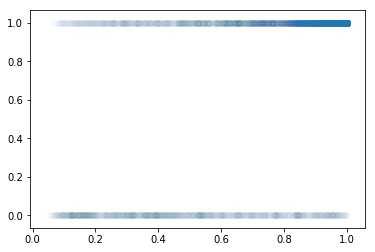

In [134]:
fig, ax = plt.subplots()
ax.scatter(y_pred_t, y_test_t, alpha=0.01)

In [135]:
fpr_t, tpr_t, thresholds_t = roc_curve(y_test_t, y_pred_t)

In [136]:
roc_auc_t = roc_auc_score(y_test_t, y_pred_t)
roc_auc_t

0.9079205840615509

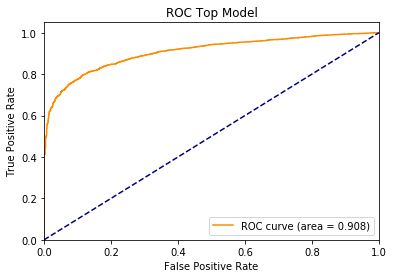

In [137]:
fig, ax = plt.subplots()
plt.plot(fpr_t, tpr_t, color='darkorange', label= f'ROC curve (area = {round(roc_auc_t, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Top Model')
plt.legend(loc="lower right")
plt.show()

# Controversy Model Baseline

In [92]:
y_test_baseline = controversy_topics_df['controversy_score']
y_pred_baseline = [y_test_baseline.mean()] * len(y_test_baseline)

In [94]:
mean_squared_error(y_test_baseline, y_pred_baseline)

0.019252957164689395

In [98]:
r2_score(y_test_baseline, y_pred_baseline)

0.0

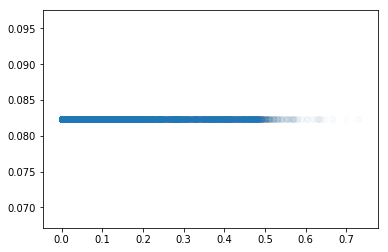

In [95]:
fig, ax = plt.subplots()
ax.scatter(y_test_baseline, y_pred_baseline, alpha=0.01)

# Controversy Top Model

In [258]:
topic_df = pd.read_csv('topic_staging_better.csv', sep="|")

In [259]:
topic_df['bill_unique'] = topic_df['biennium'] + ' ' + topic_df['bill_id'].apply(str)

In [260]:
topic_df = topic_df.drop('biennium', axis=1)

In [262]:
controversy_topics_df = controversy_X.merge(topic_df, how='left', on='bill_unique')

In [263]:
controversy_topics_df = controversy_topics_df[controversy_topics_df['HORSE'].notnull()]

In [264]:
controversy_topics_df.columns[0:20]

Index(['bill_unique', 'voter_id', 'voting_agency', 'unique_id',
       'sponsor_agency', 'party', 'is_minority_party', 'is_secondary_sponsor',
       'primary_sponsor_party', 'rep_score', 'bill_length', 'congress_num',
       'num_sponsors', 'years_until_vote', 'controversy_score', 'Unnamed: 0',
       'bill_id', 'bill_num', 'PROPERTY', 'ABORTION'],
      dtype='object')

In [236]:
# Make X and y
X = controversy_topics_df.drop(['bill_num_unique', 'bill_id', 'controversy_score', 'unique_id', 'bill_text'], 
                             axis=1)
# X = controversy_topics_df[['voter_id', 'voting_agency', 'sponsor_agency', 'party', 'is_minority_party',
#                            'is_secondary_sponsor', 'primary_sponsor_party', 'rep_score', 'bill_length', 
#                            'congress_num', 'num_sponsors', 'years_until_vote', 'bill_num']]

y = controversy_topics_df['controversy_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=709)

In [207]:
# model = RandomForestRegressor(n_estimators=2000, max_depth=6, n_jobs=2, random_state=709)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

model = GradientBoostingRegressor(loss='ls', learning_rate=0.05, n_estimators=2000, max_depth=8, random_state=709)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [230]:
mean_squared_error(y_test, y_pred)

0.01252609634833876

In [231]:
r2_score(y_test, y_pred)

0.3569525874710029

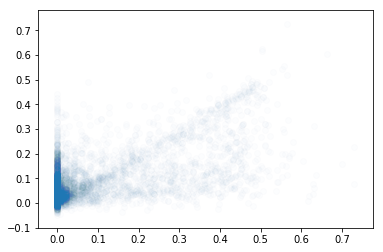

In [232]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, alpha=0.01)

In [237]:
features_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns)

In [238]:
features_importances_sorted = features_importances.sort_values(by=0, ascending=False)

In [239]:
features_importances_sorted[0:20]

,0
bill_length,0.107510
Unnamed: 0,0.102364
bill_num,0.098925
voter_id,0.085852
is_secondary_sponsor,0.070170
party,0.063457
is_minority_party,0.056239
rep_score,0.054711
voting_agency,0.041889
num_sponsors,0.032673


### NLP Playground

In [265]:
# Merge bill_text to X_train and X_test
controversy_billtext_df = controversy_topics_df.merge(bill_text_df_cleaned, how='left', on=['unique_id'])
controversy_billtext_df

,bill_unique,voter_id,voting_agency,unique_id,sponsor_agency,party,is_minority_party,is_secondary_sponsor,primary_sponsor_party,rep_score,...,LITTER,WASHINGTON STATE,CERTIFIED PROFESSIONAL GUARDIANSHIP BOARD,ELECTRICIANS,MUSICIANS,"PUBLIC GUARDIANSHIP, OFFICE",index,htm_url,bill_text,first_date_read
0,1991-92 2E2SSB 5780,275.776119,1.000000,5630.0,1.0,0.514925,0.485075,0.149254,1.0,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,493038,http://app.leg.wa.gov/documents/billdocs/1991-...,to enhancement of employment transition progr...,1991-03-11
1,1991-92 2EHB 2168,246.921569,0.000000,2321.0,0.0,0.450980,0.450980,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,396633,http://app.leg.wa.gov/documents/billdocs/1991-...,to a study of commercial vehicle weight limit...,1991-03-05
2,1991-92 2ESB 5226,281.321918,1.000000,4607.0,1.0,0.506849,0.493151,0.061644,1.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,466368,http://app.leg.wa.gov/documents/billdocs/1991-...,to terms of office; and amending rcw 43.01.01...,1991-01-24
3,1991-92 2ESB 6004,265.261780,0.471204,5986.0,1.0,0.481675,0.460733,0.000000,1.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,501556,http://app.leg.wa.gov/documents/billdocs/1991-...,to compacts negotiated under the indian gamin...,1991-06-25
4,1991-92 2ESHB 1025,249.149809,0.041985,53.0,0.0,0.451336,0.449427,0.340649,0.0,0.305556,...,0.0,0.0,0.0,0.0,0.0,0.0,302415,http://app.leg.wa.gov/documents/billdocs/1991-...,"to growth strategies."" i welcome this measur...",NaT
5,1991-92 2ESHB 1037,257.293605,0.139535,90.0,0.0,0.465116,0.465116,0.186047,0.0,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,305841,http://app.leg.wa.gov/documents/billdocs/1991-...,to crimes motivated by bigotry or bias; amend...,1991-02-12
6,1991-92 2ESHB 1058,259.265060,0.427711,141.0,0.0,0.472892,0.472892,0.012048,0.0,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,307946,http://app.leg.wa.gov/documents/billdocs/1991-...,"to treasurer-managed funds and accounts."" se...",NaT
7,1991-92 2ESHB 1198,250.700508,0.000000,433.0,0.0,0.461929,0.461929,0.086294,0.0,0.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,319908,http://app.leg.wa.gov/documents/billdocs/1991-...,to the location of electrical facilities; ame...,1991-03-06
8,1991-92 2ESHB 1378,261.875566,0.321267,816.0,0.0,0.470588,0.470588,0.061086,0.0,0.300000,...,0.0,0.0,0.0,0.0,0.0,0.0,340822,http://app.leg.wa.gov/documents/billdocs/1991-...,to superior court fees; amending rcw 36.18.02...,1991-02-28
9,1991-92 2ESHB 1430,255.395189,0.319588,918.0,0.0,0.481100,0.470790,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,345296,http://app.leg.wa.gov/documents/billdocs/1991-...,to state general obligation and revenue bonds...,1991-04-17


In [323]:
# Make X and y
X = controversy_billtext_df.drop(['bill_unique', 'bill_id', 'controversy_score', 'unique_id', 'first_date_read'], 
                             axis=1)

y = controversy_billtext_df['controversy_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=709)

In [324]:
# Identify bill text
bills_train = X_train['bill_text']
bills_test = X_test['bill_text']
len(bills_train)

8742

In [325]:
controversy_billtext_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13049 entries, 0 to 13048
Columns: 373 entries, bill_unique to first_date_read
dtypes: datetime64[ns](1), float64(366), int64(1), object(5)
memory usage: 37.2+ MB


In [326]:
my_stopwords = ['shall', 'chapter', 'provided', 'year', 'person', 'department', 'appropriation', 'provided'
                 'information', 'provide', 'including', 'following', 'section', 'sec', 'year', 'subsection', 
                'agency', 'required',  'use', 'solely', 'ii', 'defined', 'approved', 'does',  'period', 
                'rcw 43', 'persons', 'individual', 'unless', '9a', '28a', 'purpose', '28b',  'washington',  
                'fy',  'iii', 'sec rcw', 'rcw9a', 'rcw',  'apply',  '000general',  '000', 'related',  'sp', 
                'make', 'includes', 'end', 'biennia', 'set', 'terms', 'total', 'level', 'amended', 
                'engrossed', 'substitute', 'legislature', 'enacted', 'passed', 'add', 'additional', 'new', 'board',
                'limited', 'date', 'order', 'plan', 'percent', 'support', 'director', 'child', 'two', 'years', 
                'committee', 'five', 'laws', 'contract', 'prior', 'necessary', 'requirements', 'days', 'based', 
                'made', 'except', 'per', 'number', 'amounts', 'conditions', 'senate', 'house', 'system', 'may',
               'must', 'account', 'one', 'means', 'within', 'county', 'general', 'subject', 'within', 'treatment', 
               'service', 'include', 'used', 'account', 'less', 'part', 'member', 'established', 'law', 'rate', 
                'read', 'follows', 'information', 'program', 'services', 'fund', 'amount', 'agreement', 'payment',
               'commission', 'notice', 'legislature2015', '02', '1st', 'april', 'beginning', 'december', 'january', 
                'february', 'march', 'may', 'june', 'july', 'august', 'sepetmeber', 'november', 'manner', 'plans',
               'need', '060', 'sections', 'either', 'described', 'equivalent', 'recommendations', 'office', 'created',
               'higher', 'hours', 'written', 'address', 'organizations', 'value', 'party', 'full', '030', 'high', 'case',
               'four', '04', 'would', '05', 'day', 'whether', 'pass', '040', 'yeas', 'nays', 'absents', 'yea', 'nay',
                'absents', 'undecided', 'undecideds']

stop_nums = list(set([str(num) for num in range(0, 2025)]))
stopwords_nltk = list(set(stopwords.words('english')))

stopwords_nltk.extend(my_stopwords)
stopwords_nltk.extend(stop_nums)
stopwords_nltk = set(stopwords_nltk)

In [327]:
tf = TfidfVectorizer(stop_words=stopwords_nltk, ngram_range=(1, 2), max_df=0.85, max_features=8000)

In [328]:
fitted = tf.fit(bills_train)

In [329]:
transformed_train = tf.transform(bills_train)

In [330]:
transformed_test = tf.transform(bills_test)

In [331]:
def tfidf_transformed_to_dataframe(transformed):
    tfidf_cols = transformed.toarray()
    tfidf_names = fitted.get_feature_names()
    tfidf_df = pd.DataFrame(tfidf_cols, columns=tfidf_names)

    return tfidf_df

In [332]:
tfidf_train_df = tfidf_transformed_to_dataframe(transformed_train)
X_train = X_train.reset_index().drop(['index', 'bill_text', 'htm_url'], axis=1)
X_train = pd.concat([X_train, tfidf_train_df], axis=1)

In [333]:
tfidf_test_df =  tfidf_transformed_to_dataframe(transformed_test)
X_test = X_test.reset_index().drop(['index', 'bill_text', 'htm_url'], axis=1)
X_test = pd.concat([X_test, tfidf_test_df], axis=1)

In [336]:
X_train = X_train.drop('level_0', axis=1)
X_test = X_test.drop('level_0', axis=1)

In [337]:
X_train.columns[0:20]

Index(['voter_id', 'voting_agency', 'sponsor_agency', 'party',
       'is_minority_party', 'is_secondary_sponsor', 'primary_sponsor_party',
       'rep_score', 'bill_length', 'congress_num', 'num_sponsors',
       'years_until_vote', 'Unnamed: 0', 'bill_num', 'PROPERTY', 'ABORTION',
       'GOVERNMENT OPERATIONS AND POLITICS', 'ACCOUNTANTS AND ACCOUNTING',
       'CIVIL RIGHTS AND LIBERTIES, MINORITY ISSUES', 'NATROPATH'],
      dtype='object')

In [ ]:
model = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=500, max_depth=8, random_state=709)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
mean_squared_error(y_test, y_pred)

In [ ]:
r2_score(y_test, y_pred)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, alpha=0.01)

In [ ]:
features_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns)

In [ ]:
X_train.columns

In [ ]:
features_importances_sorted = features_importances.sort_values(by=0, ascending=False)

In [ ]:
features_importances_sorted